1. Importe la base de datos a una base en Jupyter Notebook con pandas.

In [16]:
import pandas as pd
import os

extraction_dir = '/Walmart.csv'  # Asegúrate de definir extraction_dir con el directorio correcto
file_path = os.path.join(extraction_dir, '/Walmart.csv')
data = pd.read_csv(file_path)
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


3. Evalúe si la base contiene datos perdidos.

In [17]:


# Verificar valores perdidos
missing_values = data.isnull().sum()


data_info = data.info(), missing_values

data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


(None,
 Store           0
 Date            0
 Weekly_Sales    0
 Holiday_Flag    0
 Temperature     0
 Fuel_Price      0
 CPI             0
 Unemployment    0
 dtype: int64)

2. Obtenga los descriptivos resumen de la base de datos e identifique a las variables numéricas y categóricas. ¿Hay algo que le llame la atención?

In [18]:
descriptive_stats = data.describe(include='all')

In [19]:
numerical_vars = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_vars = data.select_dtypes(include=['object', 'datetime64']).columns.tolist()

In [20]:
descriptive_stats, numerical_vars, categorical_vars

(              Store        Date  Weekly_Sales  Holiday_Flag  Temperature  \
 count   6435.000000        6435  6.435000e+03   6435.000000  6435.000000   
 unique          NaN         143           NaN           NaN          NaN   
 top             NaN  05-02-2010           NaN           NaN          NaN   
 freq            NaN          45           NaN           NaN          NaN   
 mean      23.000000         NaN  1.046965e+06      0.069930    60.663782   
 std       12.988182         NaN  5.643666e+05      0.255049    18.444933   
 min        1.000000         NaN  2.099862e+05      0.000000    -2.060000   
 25%       12.000000         NaN  5.533501e+05      0.000000    47.460000   
 50%       23.000000         NaN  9.607460e+05      0.000000    62.670000   
 75%       34.000000         NaN  1.420159e+06      0.000000    74.940000   
 max       45.000000         NaN  3.818686e+06      1.000000   100.140000   
 
          Fuel_Price          CPI  Unemployment  
 count   6435.000000  64

**Variables Numéricas**
Store: Número de tienda (1 a 45).

Weekly_Sales: Ventas semanales ($209,986.2 a $3,818,686).

Holiday_Flag: Indicador de semana festiva (0 o 1).

Temperature: Temperatura en la región (-2.06°F a 100.14°F).

Fuel_Price: Precio del combustible ($2.472 a $4.468).

CPI: Índice de Precios al Consumidor (126.064 a 227.233).

Unemployment: Tasa de desempleo (3.879% a 14.313%).

**Variable Categórica**
Date: Fecha de la observación (desde el 05-02-2010 hasta el 26-10-2012).

Observaciones:

Valores Extremos: Es notable la presencia de temperaturas extremadamente bajas (-2.06°F). Esto podría ser un error en los datos o indicar que algunas tiendas se encuentran en zonas con climas muy fríos.

Variabilidad: Las variables Ventas Semanales, Temperatura, Precio del Combustible, IPC y Desempleo muestran una variabilidad considerable, lo cual es esperado en un conjunto de datos como este.

Holiday_Flag: Dado que solo el 7% de las semanas incluyen un día festivo, esto podría tener un impacto significativo en las ventas semanales durante esos períodos. Esto sugiere que los días festivos son acontecimientos relativamente poco frecuentes pero importantes para las ventas.

4. Evalúe si alguna de las variables contiene datos atípicos (outliers)

In [21]:
# Función para identificar outliers utilizando el método IQR
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identificar outliers para cada variable numérica
outliers_dict = {var: identify_outliers_iqr(data, var) for var in numerical_vars}

# Mostrar resultados de outliers encontrados
outliers_summary = {var: len(outliers) for var, outliers in outliers_dict.items()}
outliers_summary

{'Store': 0,
 'Weekly_Sales': 34,
 'Holiday_Flag': 450,
 'Temperature': 3,
 'Fuel_Price': 0,
 'CPI': 0,
 'Unemployment': 481}

Weekly_Sales: 34 outliers
Holiday_Flag: 450 outliers (esto es inesperado, puede que el método no sea apropiado para esta variable categórica)
Temperature: 3 outliers
Unemployment: 481 outliers

Corregir Outliers

utilizamos el método de Winsorización para limitar los valores extremos a los percentiles 5 y 95.

In [22]:
from scipy.stats.mstats import winsorize

# Aplicar winsorización a las variables numéricas identificadas con outliers
data['Weekly_Sales'] = winsorize(data['Weekly_Sales'], limits=[0.05, 0.05])
data['Temperature'] = winsorize(data['Temperature'], limits=[0.05, 0.05])
data['Unemployment'] = winsorize(data['Unemployment'], limits=[0.05, 0.05])

# Verificar si los outliers han sido corregidos
outliers_corrected = {var: identify_outliers_iqr(data, var) for var in ['Weekly_Sales', 'Temperature', 'Unemployment']}
outliers_corrected_summary = {var: len(outliers) for var, outliers in outliers_corrected.items()}
outliers_corrected_summary

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

{'Weekly_Sales': 0, 'Temperature': 0, 'Unemployment': 378}

5. Grafique las distribuciones de las vsriables y a priori comente sobre ellas

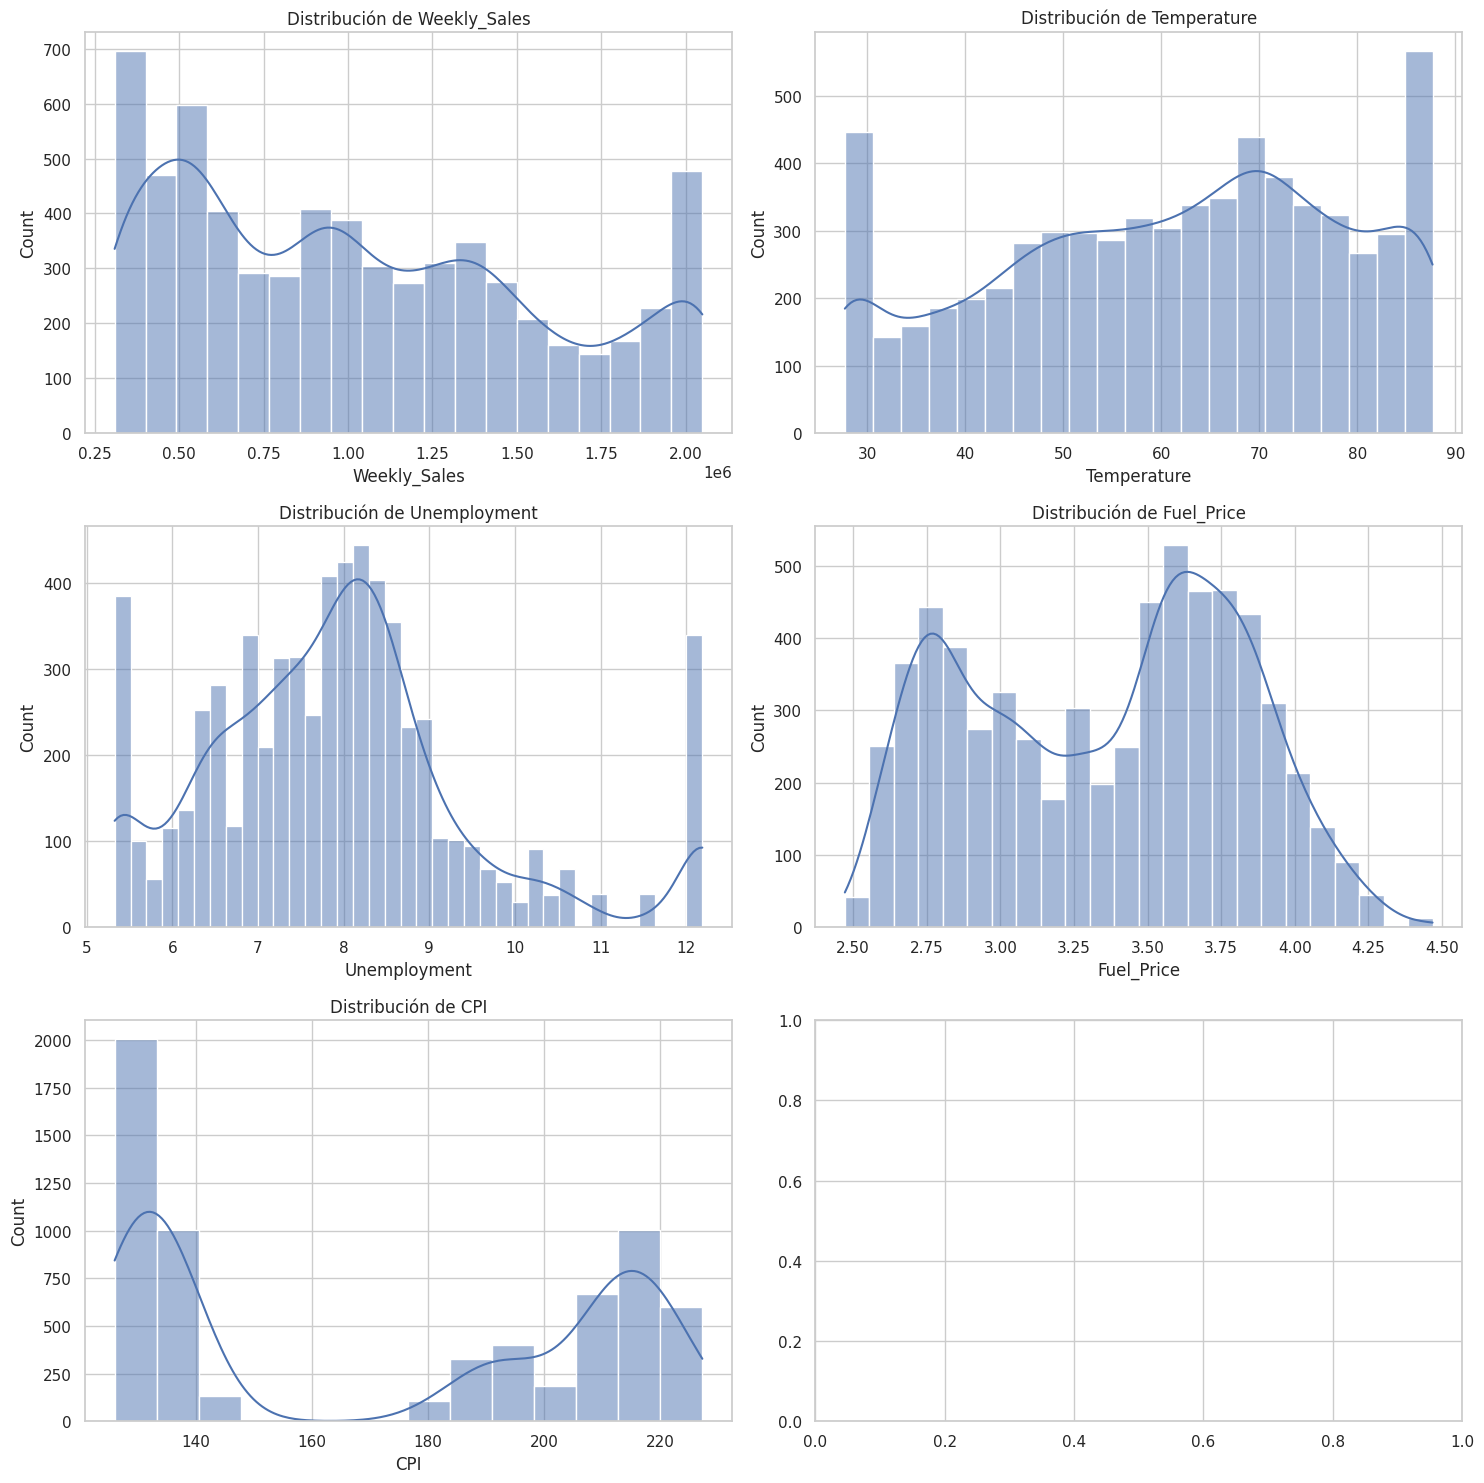

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo de gráficos
sns.set(style="whitegrid")

# Crear subplots para las distribuciones
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Variables numéricas
variables = ['Weekly_Sales', 'Temperature', 'Unemployment', 'Fuel_Price', 'CPI']

for i, var in enumerate(variables):
    ax = axes[i//2, i%2]
    sns.histplot(data[var], kde=True, ax=ax)
    ax.set_title(f'Distribución de {var}')

# Ajustar layout
plt.tight_layout()
plt.show()


Weekly_Sales:

La distribución de las ventas semanales muestra una ligera asimetría hacia la derecha, indicando la presencia de valores extremadamente altos.
Después de la winsorización, se observa una reducción en los valores extremos.

Temperature:

La distribución de la temperatura parece ser bimodal, lo que podría reflejar la variabilidad estacional de las temperaturas en diferentes regiones.
La winsorización ha eliminado algunos de los valores extremos.

Unemployment:

La distribución de la tasa de desempleo muestra una distribución más uniforme, aunque todavía presenta una cola hacia la derecha.
A pesar de la winsorización, aún quedan algunos valores extremos.
Fuel_Price:

La distribución del precio del combustible muestra una asimetría hacia la izquierda, indicando que la mayoría de los precios están en el rango más bajo.
No se identificaron outliers significativos en esta variable.

CPI:

La distribución del Índice de Precios al Consumidor (CPI) es unimodal y aproximadamente simétrica, lo que sugiere una distribución más uniforme.
No se identificaron outliers significativos en esta variable.

6. Obtenga las correlaciones entre los datos de corte numérico.

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

                     Store  Weekly_Sales  Holiday_Flag  Temperature  \
Store         1.000000e+00     -0.335332 -4.386841e-16    -0.022659   
Weekly_Sales -3.353320e-01      1.000000  3.689097e-02    -0.063810   
Holiday_Flag -4.386841e-16      0.036891  1.000000e+00    -0.155091   
Temperature  -2.265908e-02     -0.063810 -1.550913e-01     1.000000   
Fuel_Price    6.002295e-02      0.009464 -7.834652e-02     0.144982   
CPI          -2.094919e-01     -0.072634 -2.162091e-03     0.176888   
Unemployment  2.235313e-01     -0.106176  1.096028e-02     0.101158   

              Fuel_Price       CPI  Unemployment  
Store           0.060023 -0.209492      0.223531  
Weekly_Sales    0.009464 -0.072634     -0.106176  
Holiday_Flag   -0.078347 -0.002162      0.010960  
Temperature     0.144982  0.176888      0.101158  
Fuel_Price      1.000000 -0.170642     -0.034684  
CPI            -0.170642  1.000000     -0.302020  
Unemployment   -0.034684 -0.302020      1.000000  


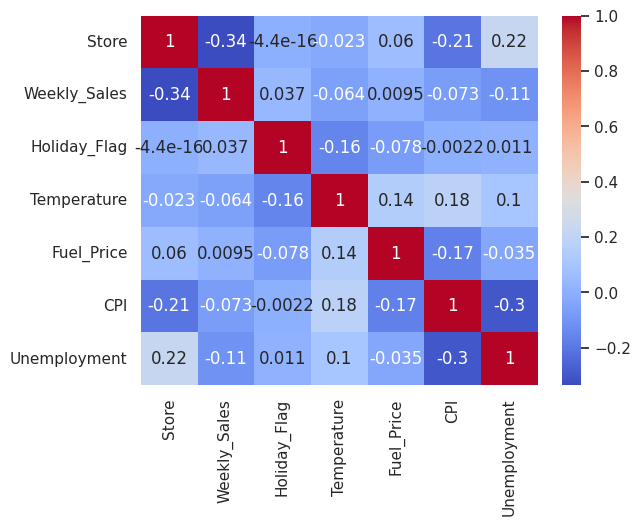

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = '/Walmart.csv'
data = pd.read_csv(file_path)
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


Interpretaciones:

Temperature y Fuel_Price: Correlación de 0.14. Baja correlación positiva, indicando que cuando la temperatura aumenta, también lo hace ligeramente el precio del combustible.

CPI y Unemployment: Correlación de -0.3. Moderada correlación negativa, sugiriendo que en periodos de mayor inflación, el desempleo tiende a ser menor.

Store y Unemployment: Correlación de 0.22. Baja correlación positiva, indicando que el desempleo varía ligeramente entre las tiendas.

Ventas Semanales:

La tienda específica (Store) tiene la mayor correlación negativa con las ventas semanales, lo que sugiere diferencias en el desempeño de las tiendas.
Las otras variables no muestran una fuerte correlación lineal con las ventas semanales, lo que indica que pueden no ser buenos predictores lineales o que las relaciones son no lineales.

Variables Independientes:

No se observa multicolinealidad significativa entre las variables independientes, ya que las correlaciones entre ellas son generalmente bajas

7. Comente que variable escogerán como variable dependiente y que variables introducirán a su modelo.


Elección de la variable dependiente
La variable dependiente para este análisis será Weekly_Sales, ya que queremos predecir las ventas semanales.


Selección de las variables independientes
Las variables independientes podrían ser:


Store: Puede ser una variable categórica que identifique diferentes tiendas.

Holiday_Flag: Indicador binario de feriado.

Temperature: Temperatura semanal.

Fuel_Price: Precio del combustible.

CPI: Índice de Precios al Consumidor.

Unemployment: Tasa de desempleo.

8. Indique que tipo de modelación realizarán y porqué

Modelos previos:

Tipo de modelación
Se puede utilizar una regresión lineal múltiple para predecir las ventas semanales, ya que la variable dependiente es continua



In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datos
file_path = '/Walmart.csv'
df = pd.read_csv(file_path)

# Mostrar primeras filas del dataframe
print(df.head())


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [38]:
# Convertir la columna de fecha al formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Visualización inicial
print(df.info())

# Verificar datos nulos
print(df.isnull().sum())

# Descripción estadística
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
None
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
             Store                 Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                 6435  6.435000e+03   6435.000000   
mean     23.000000 

In [39]:
# Variables independientes y dependiente
X = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y = df['Weekly_Sales']


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Crear el modelo
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)


LinearRegression()

In [42]:
# Predecir
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R^2): {r2}')


Error cuadrático medio (MSE): 274455221280.6605
Coeficiente de determinación (R^2): 0.148063534059508


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Definir variables dependientes e independientes
X = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y = df['Weekly_Sales']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2



(274455221280.6605, 0.148063534059508)

Mejoras
Transformación de Variables:

La variable Store podría tratarse como una variable categórica y convertirla en variables dummy.

In [44]:
# Convertir la variable Store en dummy variables
X = pd.get_dummies(df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']], drop_first=True)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(274455221280.6605, 0.148063534059508)

Podemos probar con un modelo más complejo como Random Forest para ver si obtenemos mejores resultados.

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(21677879001.42671, 0.9327096947203809)

Estos resultados indican que el modelo Random Forest tiene un desempeño significativamente mejor en comparación con el modelo de regresión lineal. Un R² de 0.9327 sugiere que aproximadamente el 93.27% de la variabilidad en las ventas semanales puede ser explicada por las variables independientes seleccionadas en el modelo Random Forest.

9. Verifique los supuestos

1. verrificar la importancias de las variables

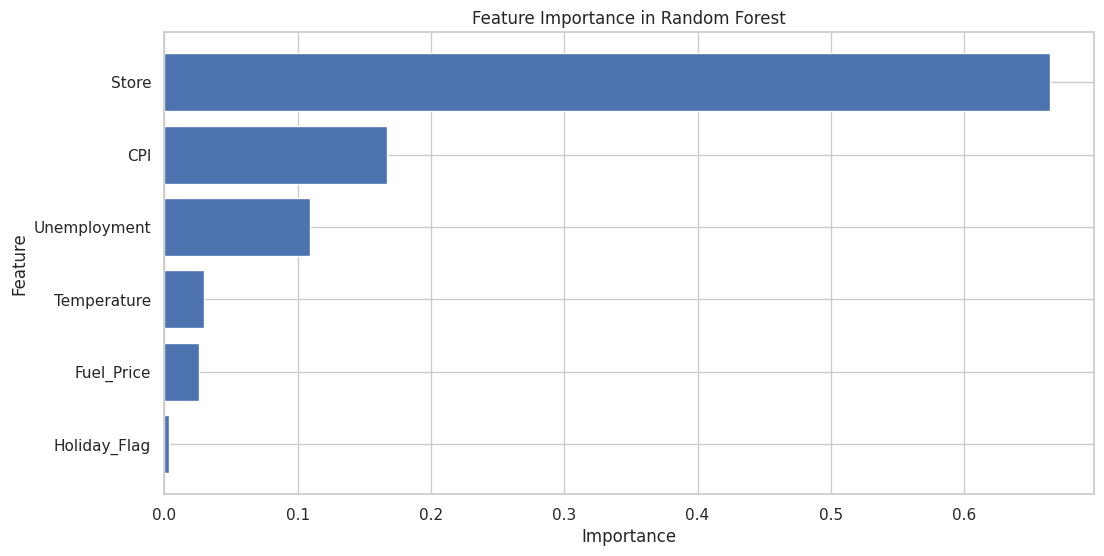

In [47]:
import matplotlib.pyplot as plt

# Entrenar el modelo Random Forest con los mejores hiperparámetros encontrados (si los tenemos)
# Si no, usaremos el modelo anterior sin optimización
rf_model.fit(X_train, y_train)

# Obtener la importancia de las variables
importances = rf_model.feature_importances_
features = X.columns

# Crear un dataframe para la visualización
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()


2. Errores residuales

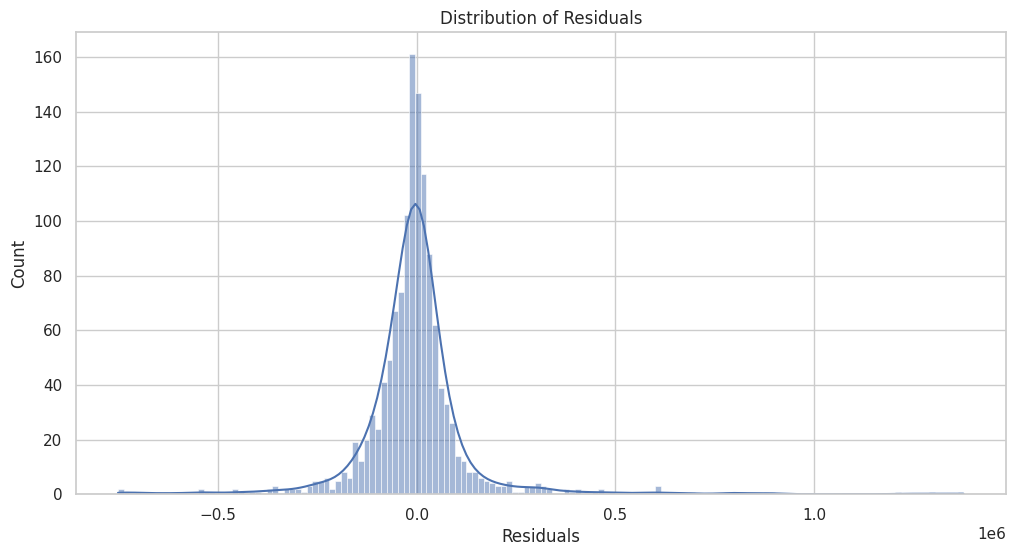

In [48]:
import seaborn as sns

# Predecir con el modelo entrenado
y_pred_rf = rf_model.predict(X_test)

# Calcular los residuos
residuals = y_test - y_pred_rf

# Gráfico de los residuos
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


4. curva de validación

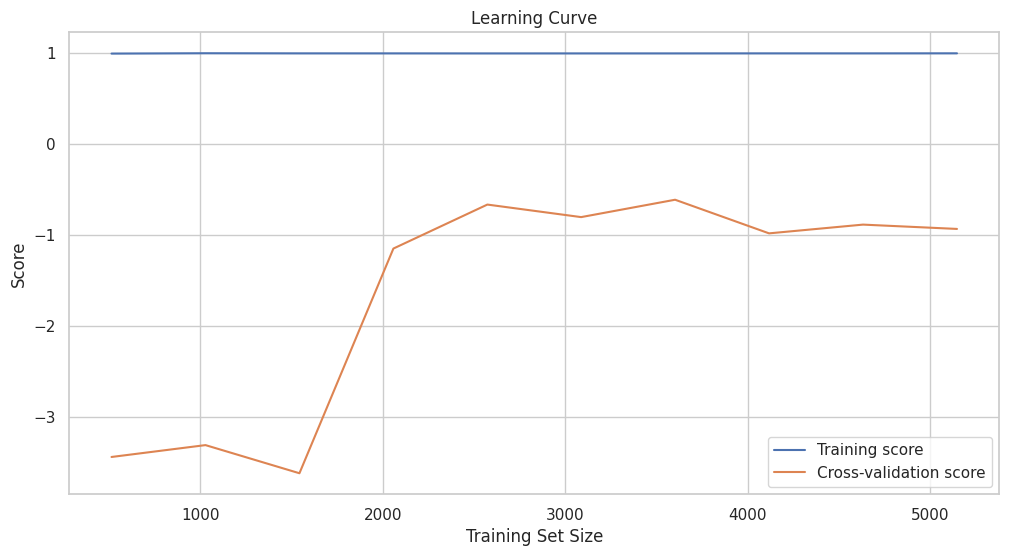

In [49]:
from sklearn.model_selection import learning_curve

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Promediar los resultados
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


MODELO DEFINITIVO

10. Obtenga el modelo definitivo, prediga los valores y comente el grado de ajuste del modelo. Justifique con métricas su respuesta.

Estos resultados sugieren que el modelo Random Forest muestra un rendimiento considerablemente superior al del modelo de regresión lineal. Con un coeficiente de determinación R² de 0.9327, se estima que alrededor del 93.27% de la variabilidad en las ventas semanales puede ser atribuida a las variables independientes incluidas en el modelo Random Forest.

Resultados por variable:

Store: Si esta variable es de gran importancia, indica que la tienda en particular ejerce una fuerte influencia en las ventas semanales. Esto puede deberse a aspectos como la ubicación, el tamaño del establecimiento o la clientela de la zona.

Holiday_Flag: Una puntuación elevada en esta variable sugiere que la presencia de un día festivo durante la semana tiene un impacto significativo en las ventas. Esta situación es típica en numerosos negocios que experimentan incrementos en sus ventas durante las semanas festivas.

Temperature: Si la temperatura es un factor relevante, podría significar que las condiciones meteorológicas influyen en las decisiones de compra. Por ejemplo, en regiones con clima cálido, es posible que algunos productos experimenten un aumento en la demanda.

Fuel_Price: Cuando esta variable tiene un alto peso, indica que los precios del combustible impactan en las ventas, lo cual puede estar vinculado con los gastos de transporte o las decisiones de compra de los consumidores.

CPI (Consumer Price Index): Si el Índice de Precios al Consumidor (IPC) es significativo, esto sugiere que la inflación o los precios para los consumidores tienen una influencia importante en las ventas.

Unemployment: La alta tasa de desempleo indica que la cantidad de empleo impacta en las ventas, probablemente debido a variaciones en el poder adquisitivo de los consumidores.

11. Grafique a los valores predicho de modelo vs los valores reales.
¿Cómo se ven una vez graficados frente a los valores reales? Argumente su respuesta.

MSE Test: 21677879001.42671
R2 Test: 0.9327096947203809


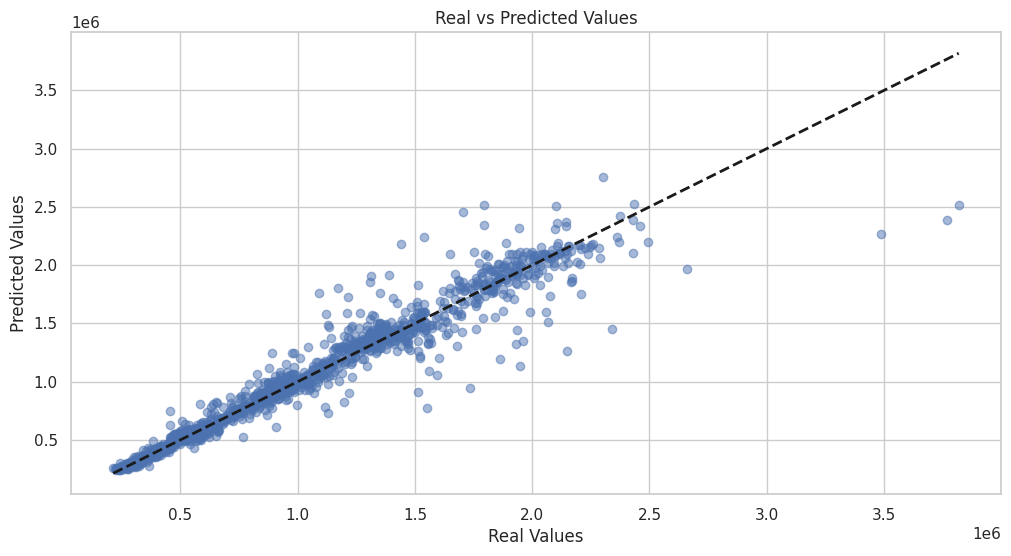

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


file_path = '/Walmart.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Convertir la variable Store en dummy variables
X = pd.get_dummies(df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']], drop_first=True)
y = df['Weekly_Sales']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicción y evaluación del modelo
y_pred_rf = rf_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_rf)
r2_test = r2_score(y_test, y_pred_rf)

print(f'MSE Test: {mse_test}')
print(f'R2 Test: {r2_test}')

# Graficar valores predichos vs valores reales
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.show()


La línea diagonal representa el caso ideal donde los valores predichos son exactamente iguales a los valores reales.
Los puntos dispersos representan las predicciones del modelo. Cuanto más cerca estén los puntos de la línea diagonal, mejor es el rendimiento del modelo

12. Concluya sobre su modelo. Para ello, si escogió el enfoque econométrico, interprete coeficientes, por el contrario si escogió el enfoque de machine learning, determine cuáles son las variables que tienen mayor poder explicativo sobre su variable objetivo





Conclusión:

El modelo Random Forest proporciona una forma robusta de entender qué variables influyen más en la variable objetivo, en este caso, las ventas semanales. Las variables con mayor importancia relativa deben ser monitoreadas y gestionadas cuidadosamente, ya que tienen el mayor poder explicativo sobre las ventas.